##Deep Learning Project
##Konstantinos Anagnostou, 02142

Comparative study of Kolmogorov-Arnold and MLP Heads for Deep Weather Image Classification


This project tackles a supervised image classification problem, aiming to classify weather images into one of 11 predefined categories

 Number of images per class:
dew: 698 images
fogsmog: 851 images
frost: 475 images
glaze: 639 images
hail: 591 images
lightning: 377 images
rain: 526 images
rainbow: 232 images
rime: 1160 images
sandstorm: 692 images
snow: 621 images


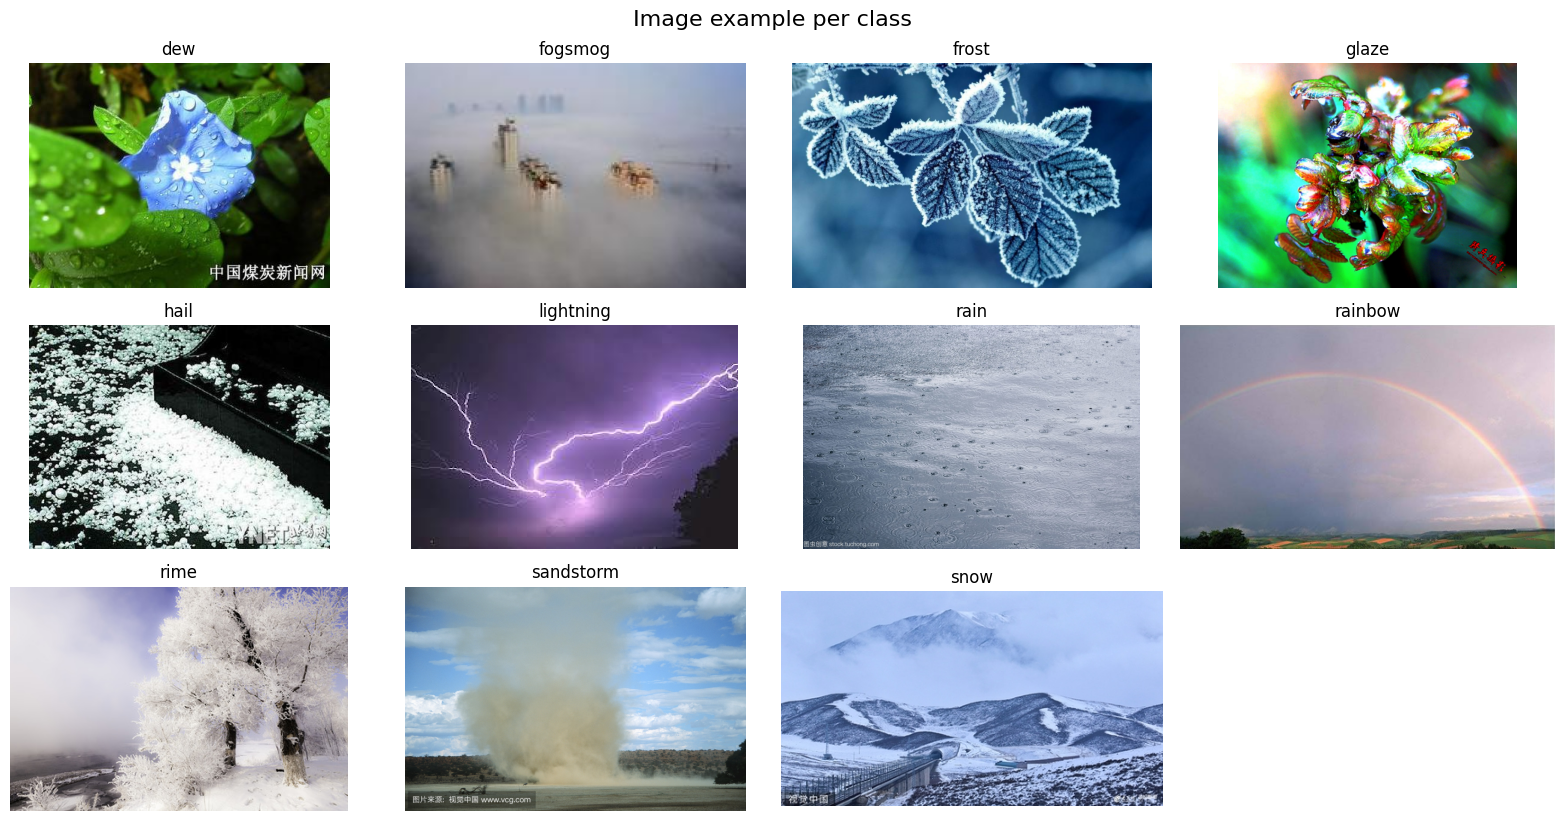

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

DATASET_PATH = "/content/weather_dataset/dataset"

class_counts = {}
class_examples = {}

for class_name in sorted(os.listdir(DATASET_PATH)):
    class_dir = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_dir):
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)
        class_examples[class_name] = os.path.join(class_dir, random.choice(image_files))

#Print #Images of every class

print(" Number of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# vistualize some images from the main set for every class
plt.figure(figsize=(16, 8))
for i, (class_name, img_path) in enumerate(class_examples.items()):
    img = mpimg.imread(img_path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.suptitle(" Image example per class ", fontsize=16, y=1.02)
plt.show()

Seperating the main dataset into train (70%) , validation (20%) and test (10%)

In [ ]:
import shutil
from tqdm import tqdm

SOURCE_DIR = "/content/weather_dataset/dataset"  # main folder
TARGET_BASE = "/content/weather_dataset/split"   # target folder
SPLIT_RATIOS = (0.7, 0.2, 0.1)  # percentece of train, val, test

assert abs(sum(SPLIT_RATIOS) - 1.0) < 1e-6


#Folders Creation

for split in ['train', 'val', 'test']:
    for class_name in os.listdir(SOURCE_DIR):
        os.makedirs(os.path.join(TARGET_BASE, split, class_name), exist_ok=True)

#File Seperation

for class_name in tqdm(os.listdir(SOURCE_DIR), desc="seperating per class"):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    total = len(images)
    train_end = int(SPLIT_RATIOS[0] * total)
    val_end = train_end + int(SPLIT_RATIOS[1] * total)

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split, split_files in splits.items():
        for file in split_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(TARGET_BASE, split, class_name, file)
            shutil.copy2(src, dst)

seperating per class: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


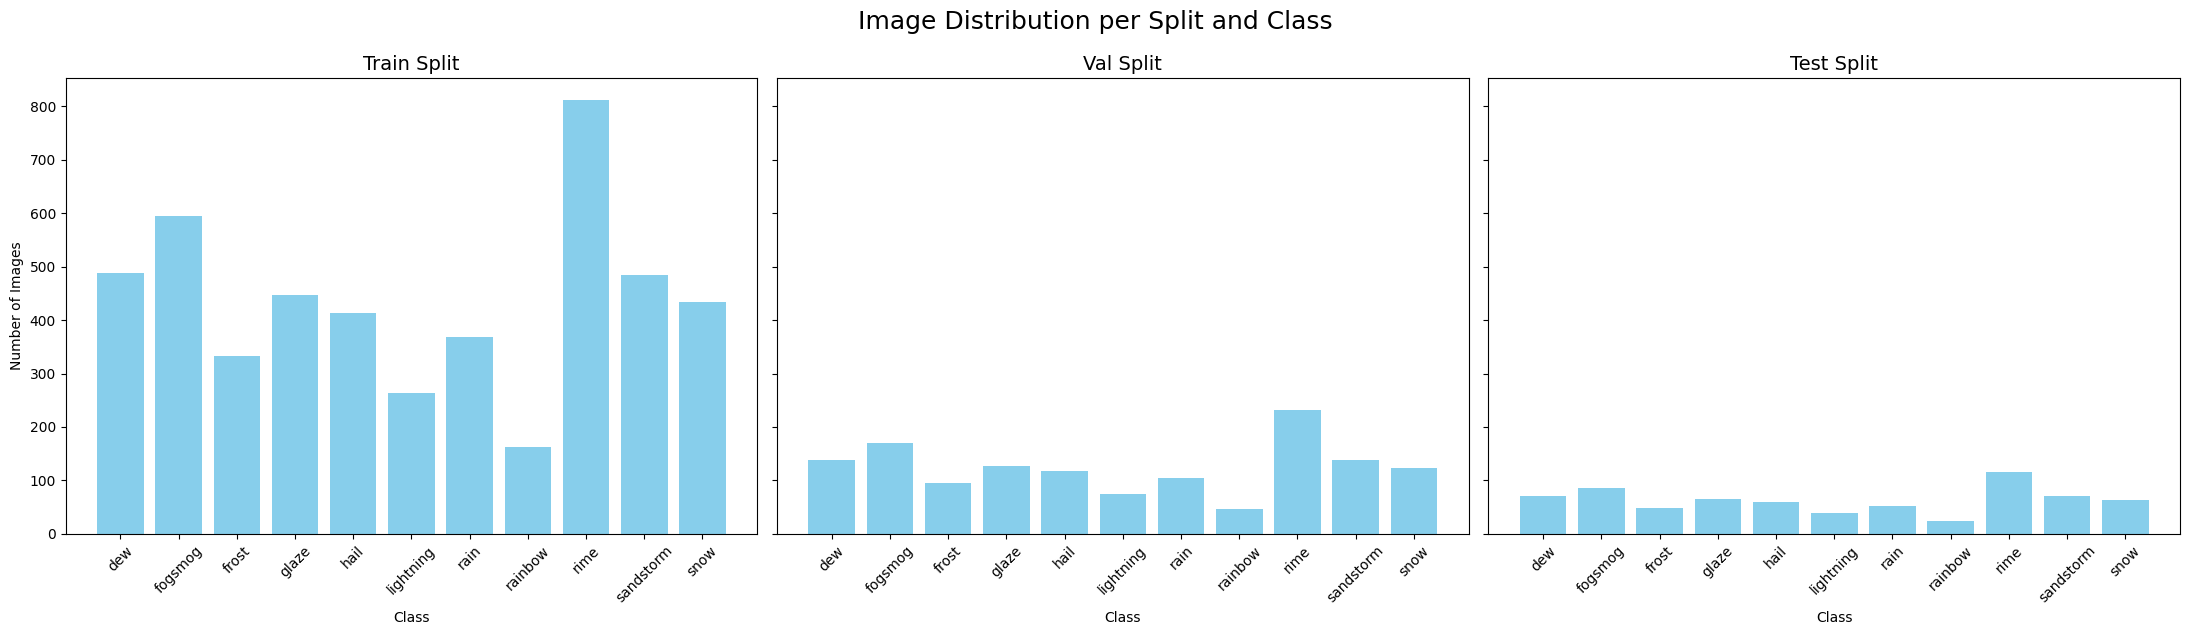

In [ ]:
from collections import defaultdict

# Base path to dataset
base_path = "/content/weather_dataset/split"
splits = ["train", "val", "test"]

# Count images per class and split
split_counts = {split: defaultdict(int) for split in splits}

for split in splits:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path):
        print(f"Folder not found: {split_path}")
        continue
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            split_counts[split][class_name] = len(image_files)

# Plot image distributions
fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=True)

for i, split in enumerate(splits):
    class_names = list(split_counts[split].keys())
    image_counts = list(split_counts[split].values())
    axes[i].bar(class_names, image_counts, color='skyblue')
    axes[i].set_title(f"{split.capitalize()} Split", fontsize=14)
    axes[i].set_xlabel("Class")
    if i == 0:
        axes[i].set_ylabel("Number of Images")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle("Image Distribution per Split and Class", fontsize=18, y=1.05)
plt.show()

#First Solution

The first solution approach adopted in this project is based on transfer learning. Specifically, the pretrained MobileNetV3 model—proposed by Howard et al. in 2019—is used as a fixed feature extractor. On top of it, a custom classification head is implemented to categorize the input images into 11 distinct weather classes

##  Head Comparison: MLP vs KAN

Liu, Ziming, et al. proposed Kolmogorov–Arnold Networks (KANs) as a novel alternative to traditional Multilayer Perceptrons (MLPs). Unlike MLPs, which rely on matrix multiplications and global dense connections, KANs replace these with learned univariate functions (basis functions) per input dimension. This structure is inspired by the Kolmogorov–Arnold representation theorem, which states that any multivariate continuous function can be decomposed into sums and compositions of univariate functions.

KANs aim to achieve:

- Improved interpretability

- Parameter efficiency

- Better generalization, especially in low-data regimes

Their experiments show that KANs can match or outperform MLPs in tasks like regression, image classification, and even symbolic reasoning — with fewer parameters and better robustness.

Both heads are evaluated using the same preprocessing, training setup, and dataset splits to ensure a fair comparison.

We analyze their performance in terms of:
- Training and validation accuracy/loss
- Final test accuracy
- Confusion matrix and classification report
- Total and trainable parameters

This comparison aims to highlight the strengths and weaknesses of each head architecture when applied to weather image classification.


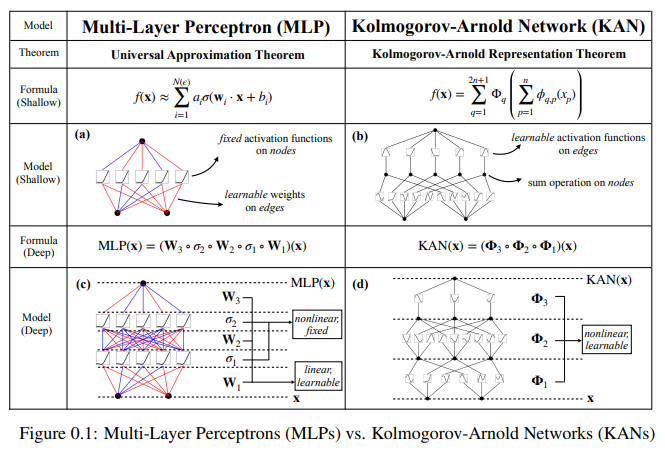

#Imports


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

try:
    from keras_efficient_kan import KANLinear
except:
    !pip install keras-efficient-kan
    from keras_efficient_kan import KANLinear

# Head type selector: "MLP" or "KAN"
#HEAD_TYPE = "MLP"


#Datasets Creation and class weights calculation



In [ ]:
BASE_PATH = "/content/weather_dataset/split"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Load raw datasets
train_ds_raw = image_dataset_from_directory(os.path.join(BASE_PATH, "train"), image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
val_ds = image_dataset_from_directory(os.path.join(BASE_PATH, "val"), image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
test_ds_raw = image_dataset_from_directory(os.path.join(BASE_PATH, "test"), image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Data augmentation + preprocessing
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

train_ds = train_ds_raw.map(lambda x, y: (data_augmentation(preprocess_input(x)), y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(AUTOTUNE)
test_ds = test_ds_raw.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(AUTOTUNE)

# Compute class weights
all_labels = [label.numpy() for _, label in train_ds_raw.unbatch()]
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = {i: w for i, w in enumerate(class_weights_array)}
print(" Class Weights:", class_weights)

Found 4798 files belonging to 11 classes.
Found 1369 files belonging to 11 classes.
Found 695 files belonging to 11 classes.
 Class Weights: {0: np.float64(0.8938152011922503), 1: np.float64(0.7330786860198625), 2: np.float64(1.3138006571741512), 3: np.float64(0.9757982509660362), 4: np.float64(1.0561303103675985), 5: np.float64(1.6584860006913238), 6: np.float64(1.1852766798418972), 7: np.float64(2.6924803591470257), 8: np.float64(0.5371697268248993), 9: np.float64(0.9012021036814425), 10: np.float64(1.0050272308336825)}


#KAN and MLP heads creation

In [ ]:
def build_model(head_type="MLP"):
    base_model = MobileNetV3Large(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    if head_type == "KAN":
        x = layers.Dropout(0.3)(x)
        x = KANLinear(units=128)(x)
        x = layers.Dropout(0.3)(x)
        x = KANLinear(units=num_classes)(x)
    else:  # MLP head
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(num_classes)(x)

    outputs = layers.Activation('softmax')(x)
    return Model(inputs, outputs), base_model

Transfer Learning with MLP head

In [ ]:
HEAD_TYPE = 'MLP'
model, base_model = build_model(HEAD_TYPE)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lr_scheduler1 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
checkpoint1 = ModelCheckpoint(f"/content/best_model_{HEAD_TYPE.lower()}_phase1.keras", monitor="val_loss", save_best_only=True, verbose=1)

history_phase1 = model.fit(train_ds,
                           validation_data=val_ds,
                           epochs=45,
                           class_weight=class_weights,
                           callbacks=[lr_scheduler1, checkpoint1])

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 11)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,120,779 (11.90 MB)

 Trainable params: 124,427 (486.04 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

Epoch 1/45
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1655 - loss: 2.7438
Epoch 1: val_loss improved from inf to 1.42699, saving model to /content/best_model_mlp_phase1.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 105s 217ms/step - accuracy: 0.1670 - loss: 2.7361 - val_accuracy: 0.6114 - val_loss: 1.4270 - learning_rate: 1.0000e-04
Epoch 2/45
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4548 - loss: 1.5599
Epoch 2: val_loss improved from 1.42699 to 0.94746, saving model to /content/best_model_mlp_phase1.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4553 - loss: 1.5589 - val_accuracy: 0.7414 - val_loss: 0.9475 - learning_rate: 1.0000e-04
Epoch 3/45
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6082 - loss: 1.1642
Epoch 3: val_loss improved from 0.94746 to 0.71593, saving model to /content/best_model_mlp_phase1.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6083 - loss: 1.1637 - val_accuracy: 0.7867 - val_loss: 0.7159 - learning_rate

At this stage, I unfreeze some of the base (MobileNetV3Large) model layers and continue training along with the MLP head

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lr_scheduler2 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
checkpoint2 = ModelCheckpoint(f"/content/best_model_{HEAD_TYPE.lower()}_phase2.keras", monitor="val_loss", save_best_only=True, verbose=1)

history_phase2 = model.fit(train_ds,
                           validation_data=val_ds,
                           epochs=35,
                           class_weight=class_weights,
                           callbacks=[lr_scheduler2, checkpoint2])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 11)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,369,635 (12.85 MB)

 Trainable params: 2,964,323 (11.31 MB)

 Non-trainable params: 156,456 (611.16 KB)

 Optimizer params: 248,856 (972.10 KB)

Epoch 1/35
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8891 - loss: 0.2765
Epoch 1: val_loss improved from inf to 0.35903, saving model to /content/best_model_mlp_phase2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 177ms/step - accuracy: 0.8891 - loss: 0.2763 - val_accuracy: 0.8787 - val_loss: 0.3590 - learning_rate: 1.0000e-05
Epoch 2/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9030 - loss: 0.2387
Epoch 2: val_loss improved from 0.35903 to 0.35145, saving model to /content/best_model_mlp_phase2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9030 - loss: 0.2387 - val_accuracy: 0.8817 - val_loss: 0.3514 - learning_rate: 1.0000e-05
Epoch 3/35
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9065 - loss: 0.2306
Epoch 3: val_loss improved from 0.35145 to 0.34682, saving model to /content/best_model_mlp_phase2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9066 - loss: 0.2305 - val_accuracy: 0.8882 - val_loss: 0.3468 - learning_rat

In [ ]:
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    plt.tight_layout()
    plt.show()

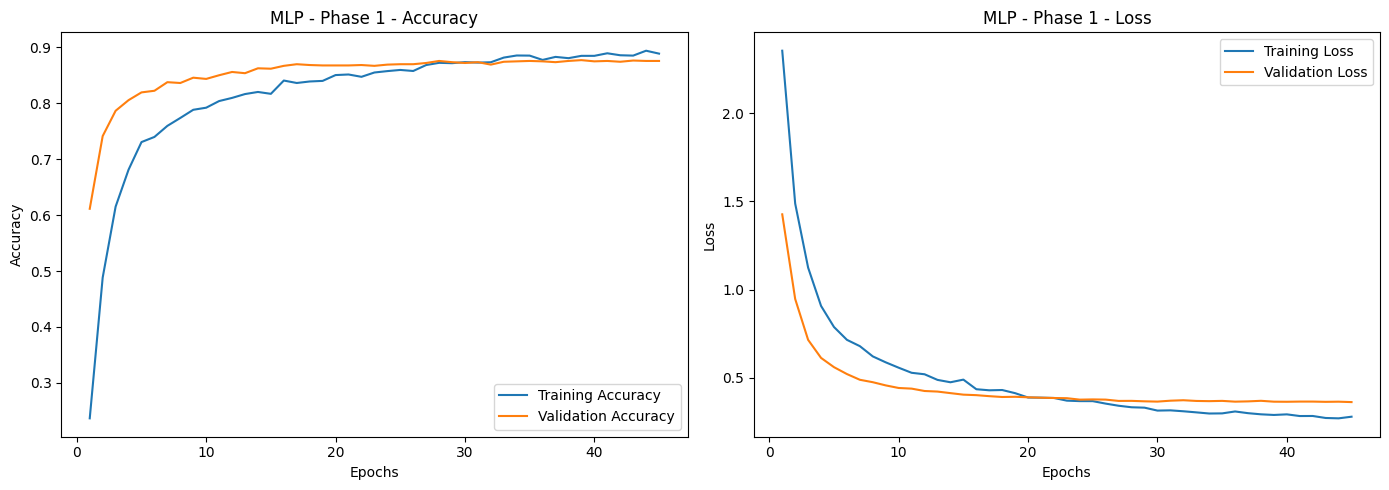

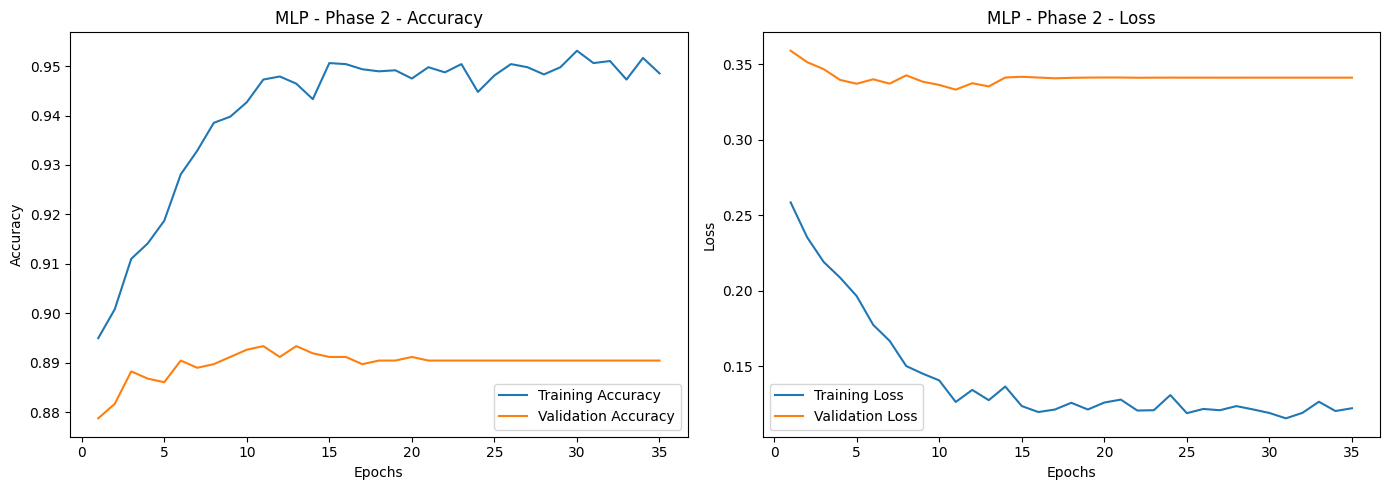

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

 Final Test Accuracy: 0.9122302158273381

 Classification Report:
              precision    recall  f1-score   support

         dew       0.95      0.97     

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


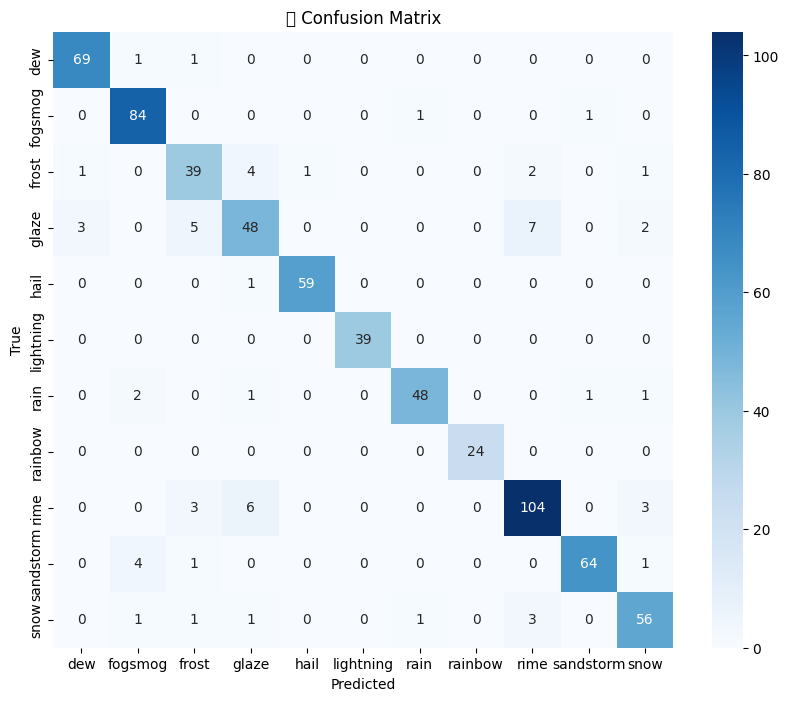

In [ ]:
plot_training_history(history_phase1, f"{HEAD_TYPE} - Phase 1")
plot_training_history(history_phase2, f"{HEAD_TYPE} - Phase 2")

# Final Evaluation
y_true, y_pred, raw_images = [], [], []
for (images, labels), (raw_batch, _) in zip(test_ds, test_ds_raw):
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    raw_images.extend(raw_batch.numpy() / 255.0)

print("\n Final Test Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title(" Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

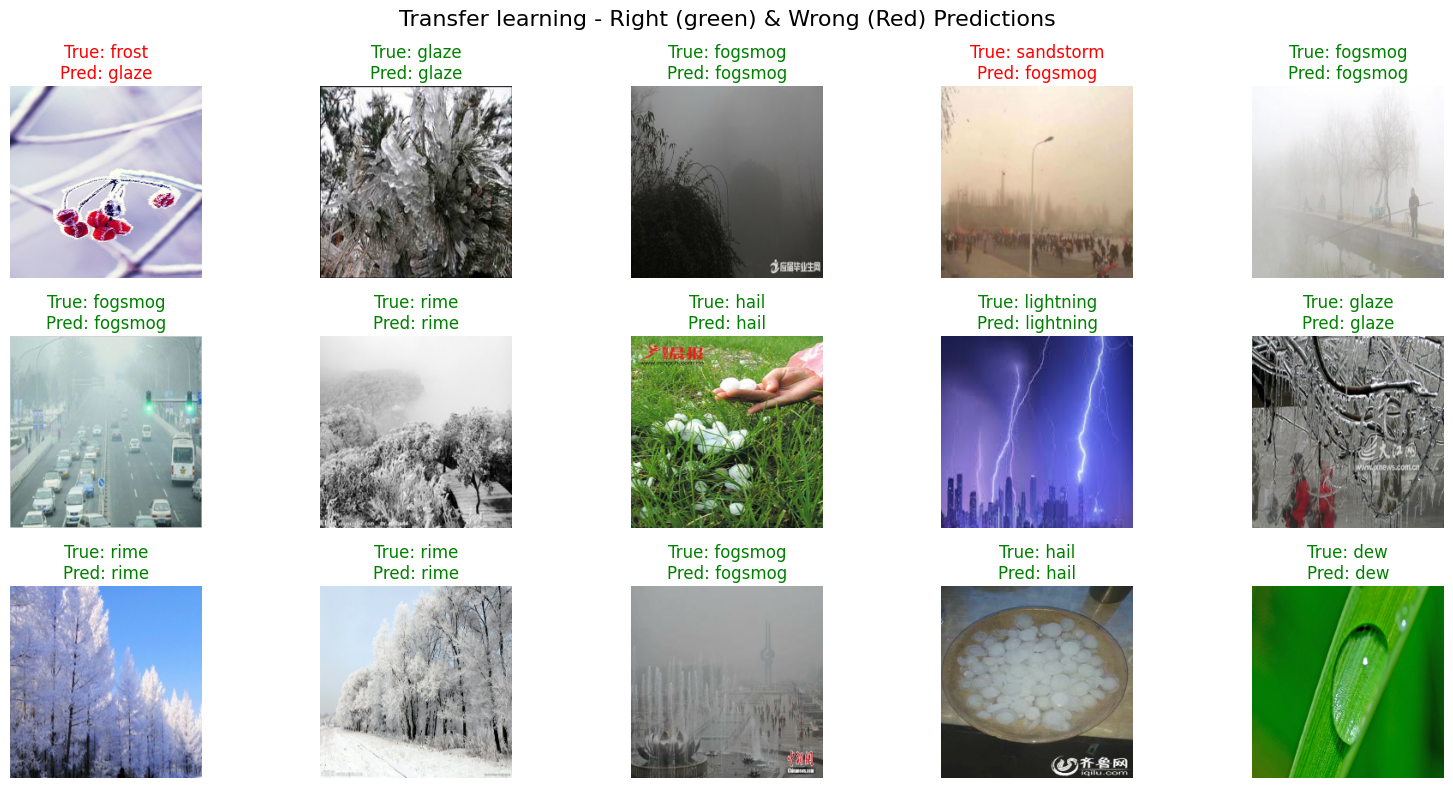

In [ ]:
num_samples = 15
indices = random.sample(range(len(raw_images)), num_samples)

plt.figure(figsize=(16, 8))
for i, idx in enumerate(indices):
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = 'green' if true_label == pred_label else 'red'

    plt.subplot(3, 5, i + 1)
    plt.imshow(raw_images[idx])
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')

plt.suptitle("Transfer learning - Right (green) & Wrong (Red) Predictions", fontsize=16)
plt.tight_layout()
plt.show()

Transfer Learning with KAN head


In [ ]:
HEAD_TYPE = 'KAN'
model, base_model = build_model(HEAD_TYPE)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lr_scheduler1 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
checkpoint1 = ModelCheckpoint(f"/content/best_model_{HEAD_TYPE.lower()}_phase1.keras", monitor="val_loss", save_best_only=True, verbose=1)

history_phase1 = model.fit(train_ds,
                           validation_data=val_ds,
                           epochs=45,
                           class_weight=class_weights,
                           callbacks=[lr_scheduler1, checkpoint1])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kan_linear (KANLinear)          │ (None, 128)            │       871,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kan_linear_1 (KANLinear)        │ (None, 11)             │        11,403 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 11)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,879,563 (14.80 MB)

 Trainable params: 872,331 (3.33 MB)

 Non-trainable params: 3,007,232 (11.47 MB)

Epoch 1/45
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2073 - loss: 2.2621
Epoch 1: val_loss improved from inf to 1.24087, saving model to /content/best_model_kan_phase1.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.2086 - loss: 2.2590 - val_accuracy: 0.6406 - val_loss: 1.2409 - learning_rate: 1.0000e-04
Epoch 2/45
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5304 - loss: 1.4835
Epoch 2: val_loss improved from 1.24087 to 0.84489, saving model to /content/best_model_kan_phase1.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.5307 - loss: 1.4829 - val_accuracy: 0.7531 - val_loss: 0.8449 - learning_rate: 1.0000e-04
Epoch 3/45
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6537 - loss: 1.0831
Epoch 3: val_loss improved from 0.84489 to 0.69342, saving model to /content/best_model_kan_phase1.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6541 - loss: 1.0826 - val_accuracy: 0.7728 - val_loss: 0.6934 - learning_rate

At this stage, I unfreeze some of the base (MobileNetV3Large) model layers and continue training along with the KAN head

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lr_scheduler2 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
checkpoint2 = ModelCheckpoint(f"/content/best_model_{HEAD_TYPE.lower()}_phase2.keras", monitor="val_loss", save_best_only=True, verbose=1)

history_phase2 = model.fit(train_ds,
                           validation_data=val_ds,
                           epochs=35,
                           class_weight=class_weights,
                           callbacks=[lr_scheduler2, checkpoint2])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kan_linear (KANLinear)          │ (None, 128)            │       871,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kan_linear_1 (KANLinear)        │ (None, 11)             │        11,403 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 11)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,624,227 (21.45 MB)

 Trainable params: 3,712,227 (14.16 MB)

 Non-trainable params: 167,336 (653.66 KB)

 Optimizer params: 1,744,664 (6.66 MB)

Epoch 1/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9157 - loss: 0.2270
Epoch 1: val_loss improved from inf to 0.36017, saving model to /content/best_model_kan_phase2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 181ms/step - accuracy: 0.9158 - loss: 0.2270 - val_accuracy: 0.8766 - val_loss: 0.3602 - learning_rate: 1.0000e-05
Epoch 2/35
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9281 - loss: 0.2092
Epoch 2: val_loss improved from 0.36017 to 0.34824, saving model to /content/best_model_kan_phase2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9281 - loss: 0.2091 - val_accuracy: 0.8875 - val_loss: 0.3482 - learning_rate: 1.0000e-05
Epoch 3/35
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9385 - loss: 0.1837
Epoch 3: val_loss improved from 0.34824 to 0.34690, saving model to /content/best_model_kan_phase2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9384 - loss: 0.1837 - val_accuracy: 0.8817 - val_loss: 0.3469 - learning_rat

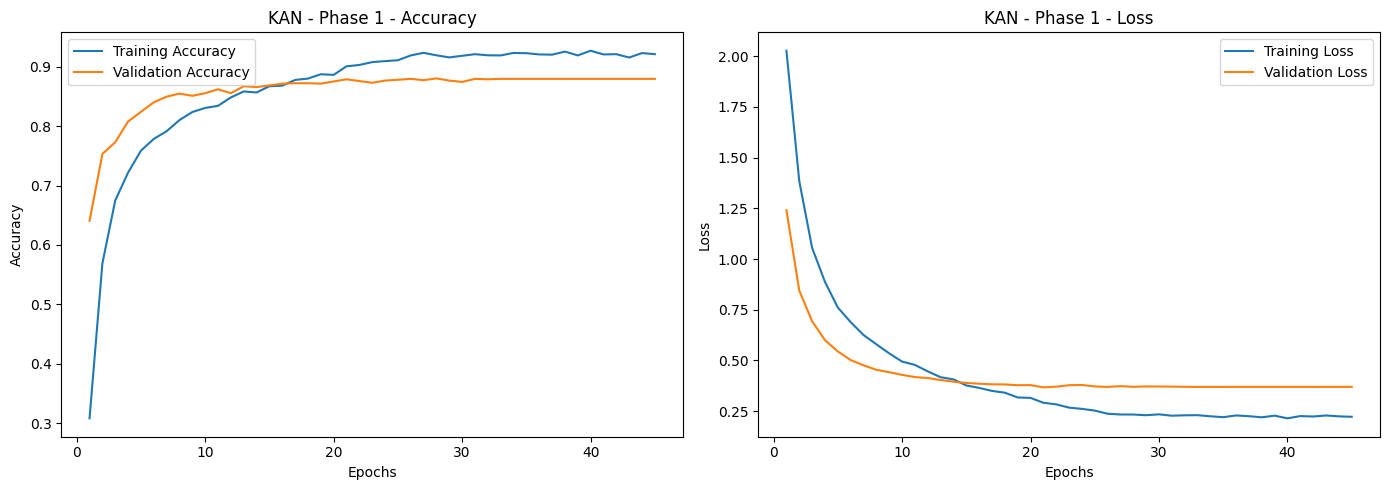

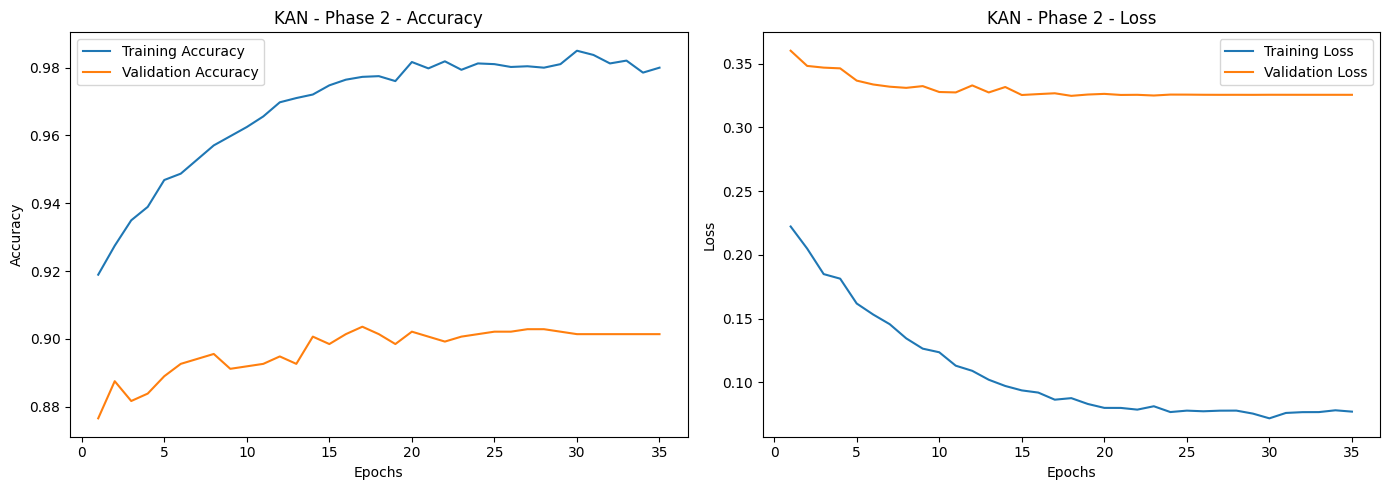

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

 Final Test Accuracy: 0.9294964028776979

 Classification Report:
              precision    recall  f1-score   support

         dew       0.96      1.00      0.98

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


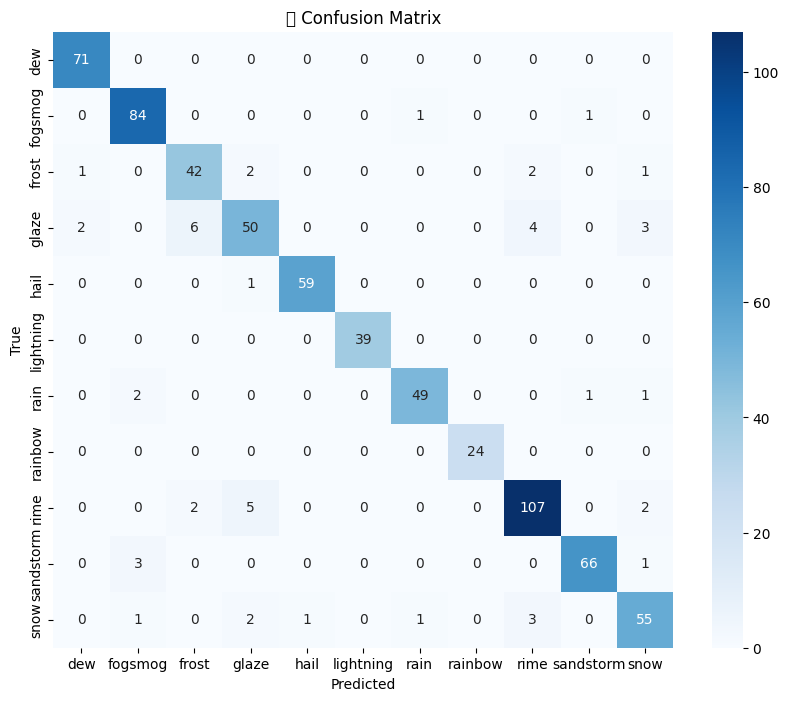

In [ ]:
plot_training_history(history_phase1, f"{HEAD_TYPE} - Phase 1")
plot_training_history(history_phase2, f"{HEAD_TYPE} - Phase 2")

# Final Evaluation
y_true, y_pred, raw_images = [], [], []
for (images, labels), (raw_batch, _) in zip(test_ds, test_ds_raw):
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    raw_images.extend(raw_batch.numpy() / 255.0)

print("\n Final Test Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title(" Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


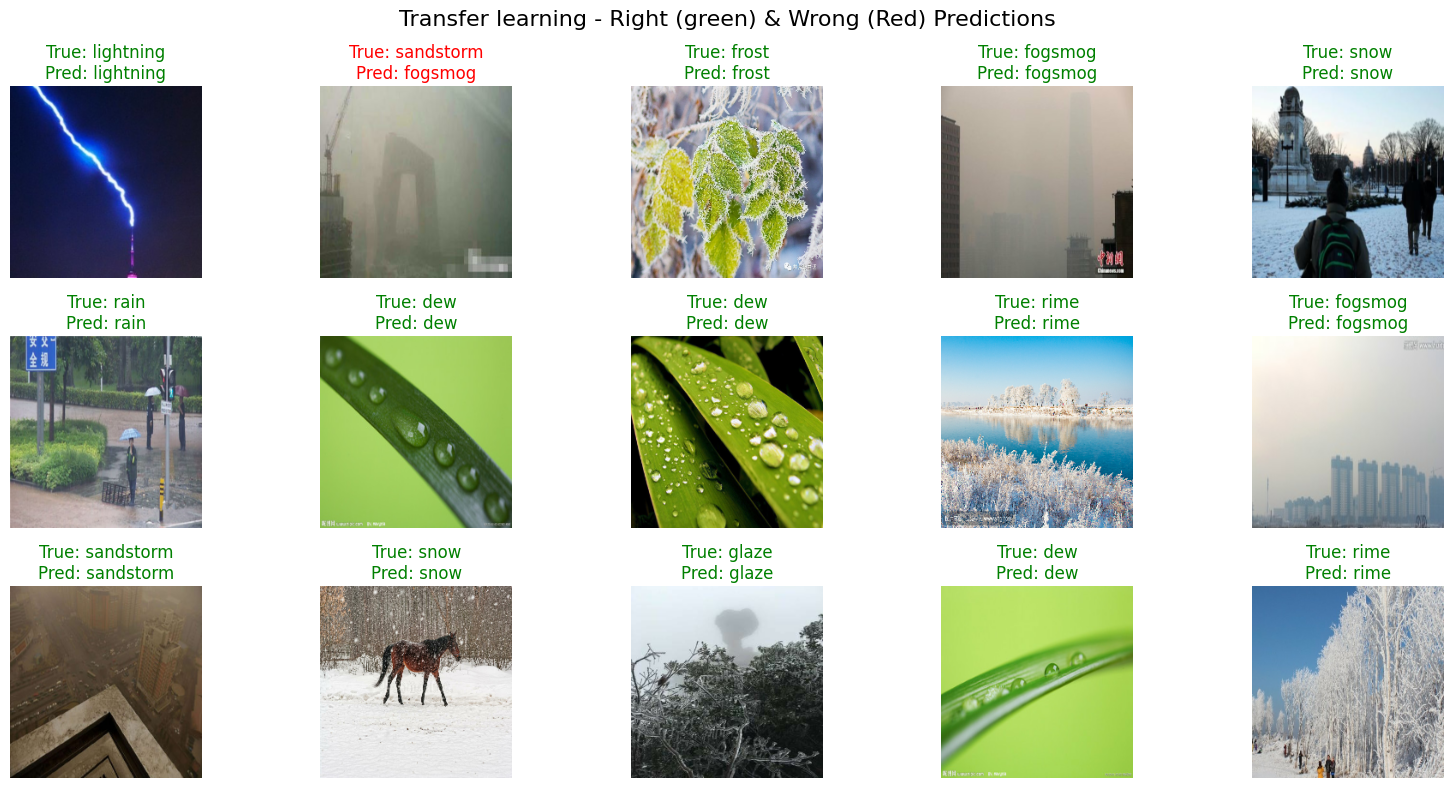

In [ ]:
num_samples = 15
indices = random.sample(range(len(raw_images)), num_samples)

plt.figure(figsize=(16, 8))
for i, idx in enumerate(indices):
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = 'green' if true_label == pred_label else 'red'

    plt.subplot(3, 5, i + 1)
    plt.imshow(raw_images[idx])
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')

plt.suptitle("Transfer learning - Right (green) & Wrong (Red) Predictions", fontsize=16)
plt.tight_layout()
plt.show()

#Last but not least , a baseline custom CNN model



Found 4798 files belonging to 11 classes.
Found 1369 files belonging to 11 classes.
Found 695 files belonging to 11 classes.
 Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
 Class Weights: {0: np.float64(0.8938152011922503), 1: np.float64(0.7330786860198625), 2: np.float64(1.3138006571741512), 3: np.float64(0.9757982509660362), 4: np.float64(1.0561303103675985), 5: np.float64(1.6584860006913238), 6: np.float64(1.1852766798418972), 7: np.float64(2.6924803591470257), 8: np.float64(0.5371697268248993), 9: np.float64(0.9012021036814425), 10: np.float64(1.0050272308336825)}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 458,955 (1.75 MB)

 Trainable params: 457,995 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 151ms/step - accuracy: 0.3884 - loss: 1.8477 - val_accuracy: 0.1782 - val_loss: 3.5080 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - accuracy: 0.5291 - loss: 1.3813 - val_accuracy: 0.3682 - val_loss: 2.0517 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5742 - loss: 1.2382 - val_accuracy: 0.5157 - val_loss: 1.4569 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6118 - loss: 1.1840 - val_accuracy: 0.4660 - val_loss: 1.8876 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6337 - loss: 1.0828 - val_accuracy: 0.3762 - val_loss: 2.0189 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6318 - loss: 1.0791
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.6318 - lo

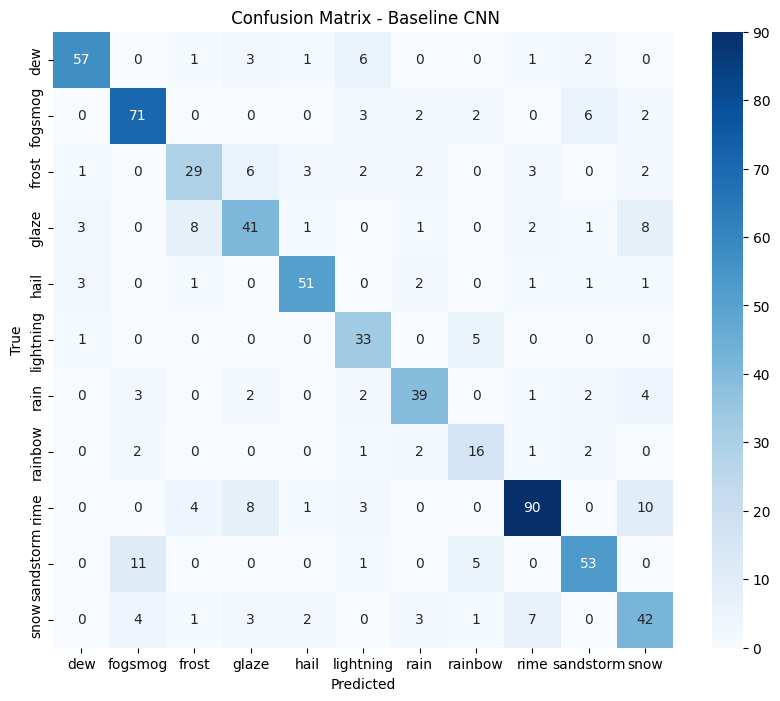

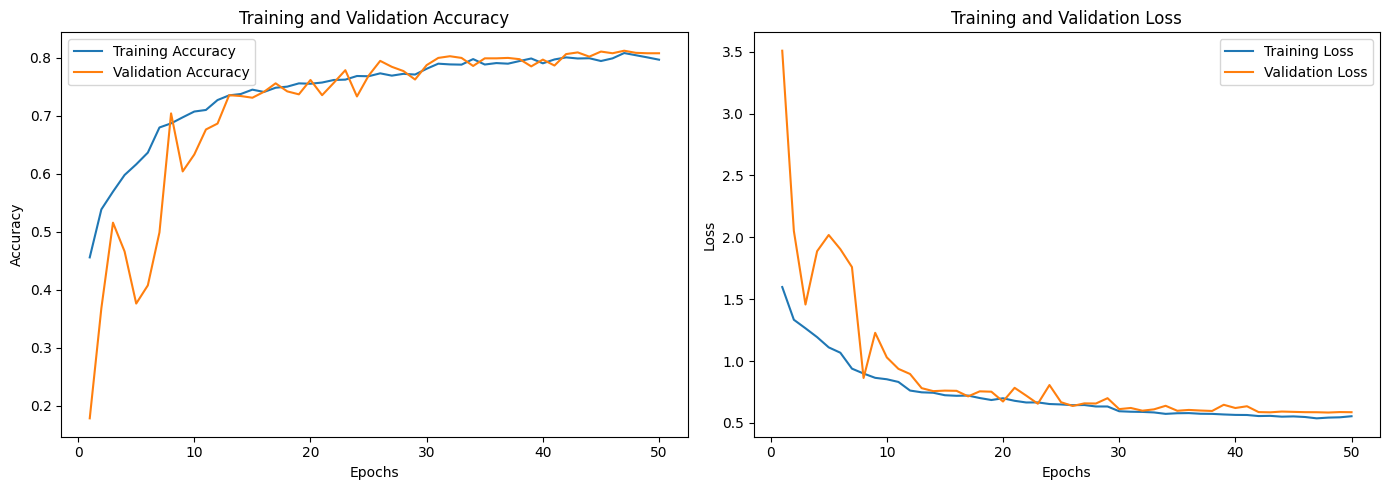

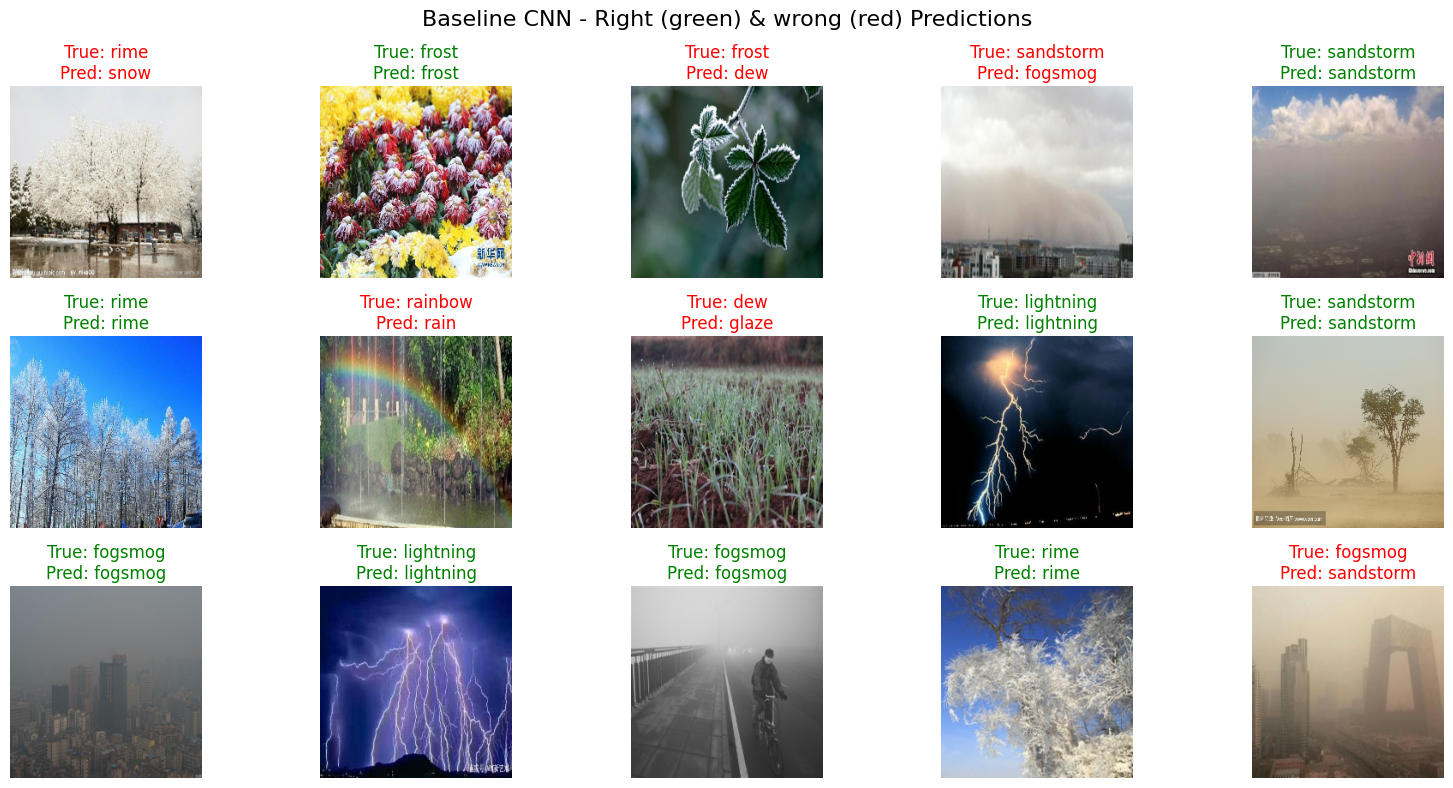

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
BASE_PATH = "/content/weather_dataset/split"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds_raw = image_dataset_from_directory(
    os.path.join(BASE_PATH, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    os.path.join(BASE_PATH, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    os.path.join(BASE_PATH, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds_raw.class_names
num_classes = len(class_names)
print(" Classes:", class_names)


# Preprocessing & class weights

train_ds = train_ds_raw.map(lambda x, y: (x / 255.0, y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (x / 255.0, y)).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y)).cache().prefetch(AUTOTUNE)

all_labels = []
for _, labels in train_ds_raw.unbatch():
    all_labels.append(labels.numpy())

class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = {i: w for i, w in enumerate(class_weights_array)}
print(" Class Weights:", class_weights)


# Define custom CNN model

def build_advanced_cnn(input_shape=(224, 224, 3), num_classes=11):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


# Callbacks: EarlyStopping + LR Scheduler

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)


#  Compile & Fit

advanced_model = build_advanced_cnn(input_shape=IMG_SIZE + (3,), num_classes=num_classes)

advanced_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

advanced_model.summary()

history_advanced = advanced_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler]
)


#  Evaluation in test set

y_true, y_pred, image_batch = [], [], []

for images, labels in test_ds:
    preds = advanced_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    image_batch.extend(images.numpy())

test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n Baseline CNN Test Accuracy: {test_accuracy:.4f}")

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title(" Confusion Matrix - Baseline CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#  Accuracy & Loss Curves

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_advanced)


#  Sample random Predictions Visualization

num_samples = 15
indices = random.sample(range(len(image_batch)), num_samples)

plt.figure(figsize=(16, 8))
for i, idx in enumerate(indices):
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = 'green' if true_label == pred_label else 'red'

    plt.subplot(3, 5, i + 1)
    plt.imshow(image_batch[idx])
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')

plt.suptitle("Baseline CNN - Right (green) & wrong (red) Predictions", fontsize=16)
plt.tight_layout()
plt.show()

Approach  Test Accuracy Trainable Parameters  \
0  Transfer Learning + MLP Head           0.91            2.964.323   
1  Transfer Learning + KAN Head           0.93            3.712.227   
2           Baseline Custom CNN           0.75              458.955   

                      Model File  
0  mobilenetv3_weather_mlp.keras  
1  mobilenetv3_weather_kan.keras  
2     baseline_cnn_weather.keras

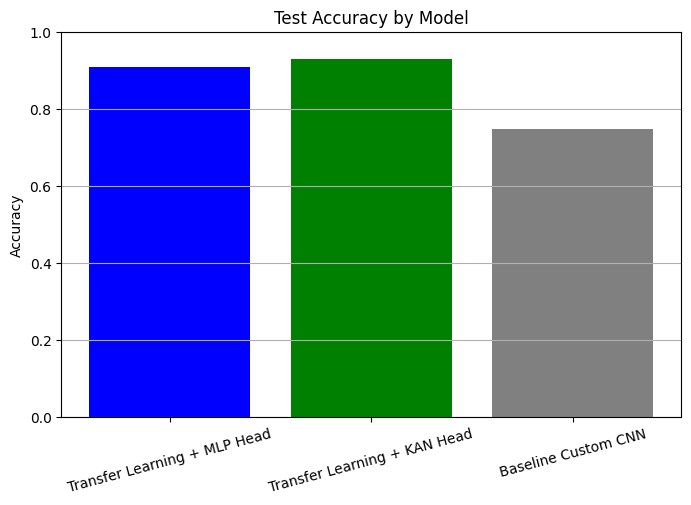

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the final table for comparison
results_data = {
    "Approach": ["Transfer Learning + MLP Head", "Transfer Learning + KAN Head", "Baseline Custom CNN"],
    "Test Accuracy": [0.91, 0.93, 0.75],
    "Trainable Parameters": ['2.964.323', '3.712.227',  '458.955'],
    "Model File": [
        "mobilenetv3_weather_mlp.keras",
        "mobilenetv3_weather_kan.keras",
        "baseline_cnn_weather.keras"
    ]
}

results_df = pd.DataFrame(results_data)
display(results_df)


plt.figure(figsize=(8, 5))
plt.bar(results_df["Approach"], results_df["Test Accuracy"], color=["blue", "green", "gray"])
plt.title("Test Accuracy by Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.show()


The table above summarizes the performance of three different approaches for solving the 11-class weather image classification task. We compare transfer learning using a pretrained MobileNetV3 backbone with two different classification heads — a standard MLP and a KAN-based architecture — as well as a fully custom CNN trained from scratch. The KAN head achieved the highest test accuracy, indicating its potential to generalize better when used as a differentiable spline-based alternative to MLPs.

#References

[1] Liu, Ziming, et al. "Kan: Kolmogorov-arnold networks." arXiv preprint arXiv:2404.19756 (2024)

[2] Weiss, Karl, Taghi M. Khoshgoftaar, and DingDing Wang. "A survey of transfer learning." Journal of Big data 3 (2016): 1-40.

[3] Pinkus, Allan. "Approximation theory of the MLP model in neural networks." Acta numerica 8 (1999): 143-195.

[4] Avanaki, Nasim Jamshidi, et al. "LAR-IQA: A Lightweight, Accurate, and Robust No-Reference Image Quality Assessment Model." arXiv preprint arXiv:2408.17057 (2024).

[5] Howard, Andrew, et al. "Searching for mobilenetv3." Proceedings of the IEEE/CVF international conference on computer vision. 2019.